## Importing everything

In [4]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
# try: # detect if the notebook runs in Colab
#     import google.colab
#     colab_compat = True # deactivate preview
# except:
#     colab_compat = False
# resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna
except ImportError as e:
    print(f'could not import sionna')
#     # Install Sionna if package is not already installed
#     import os
#     os.system("pip install sionna")
#     import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f'gpus: {gpus}')
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
else:
    print(f'no gpu detected')
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility


no gpu detected
Num GPUs Available:  0


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement


AttributeError: jit_init_thread_state(): the LLVM backend is inactive because the LLVM shared library ("LLVM-C.dll") could not be found! Set the DRJIT_LIBLLVM_PATH environment variable to specify its path.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting up the environment

In [ ]:
# Load custom scene
scene = load_scene(r"/content/drive/MyDrive/6G_tandem_sionna/tp_room_3/room - adjusted.xml") # Try also sionna.rt.scene.etoile
#scene = load_scene(r"/content/drive/MyDrive/6G_tandem_sionna/tp_room_3/room_adjusted_no_walls.xml") # Try also sionna.rt.scene.etoile


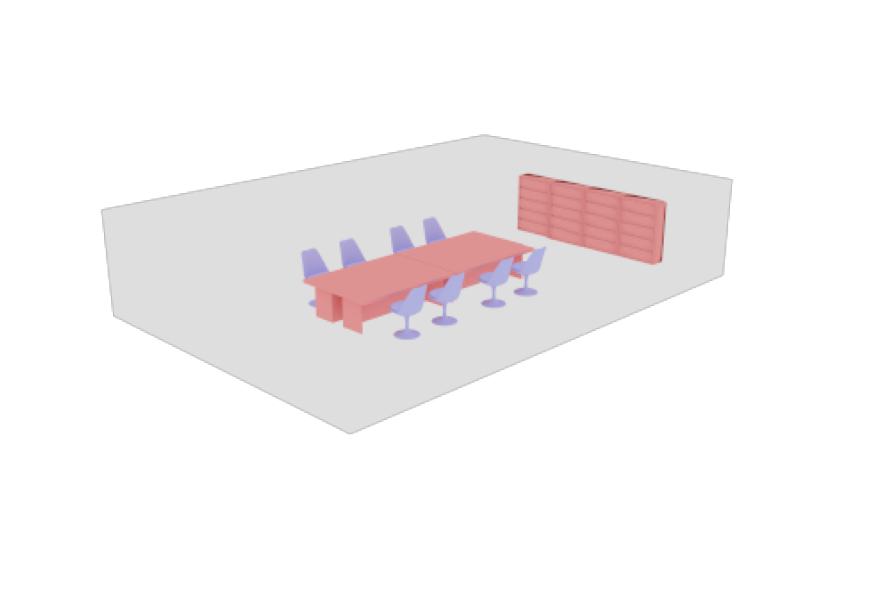

In [ ]:
# Create new camera with different configuration
mycam = 'my_cam4'
my_cam = Camera(mycam, position=[20,20,10], look_at=[0,0,0])
scene.add(my_cam)

# Render scene with new camera*
scene.render(mycam, resolution=resolution, num_samples=1024); # Increase num_samples to increase image quality

## Ray Tracing

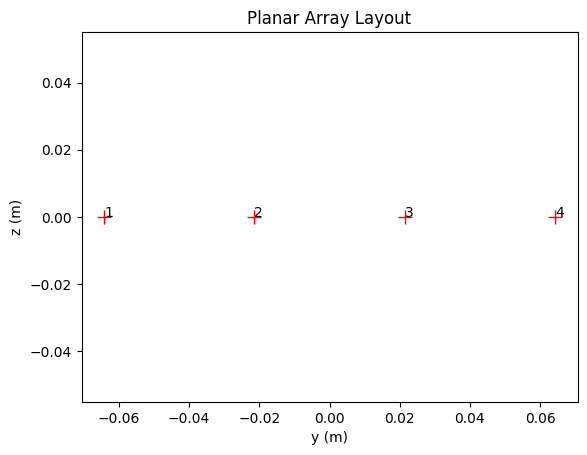

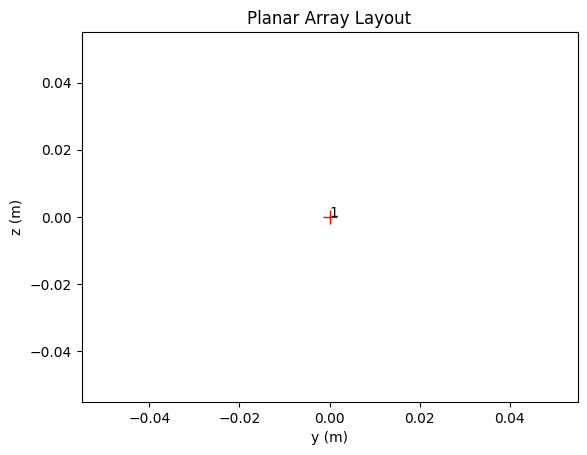

In [ ]:
# Configure antenna array for all transmitters
# todo adjust nr antennas etc
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=4,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

scene.tx_array.show()

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

scene.rx_array.show()


# Create transmitter
tx = Transmitter(name="tx",
                 position=[0.0,0.0,2.5])

# Add transmitter instance to scene
scene.add(tx)

"""todo:
just add a new receiver for each location we want to have a channel for?,
in that way we can even plot all receiver locations in one map
"""

# Create a receiver => can we adjust this based on Alex's data? and visuallize this?
rx = Receiver(name="rx",
              position=[2,2,1.5],
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver

In [ ]:
# set frequency
scene.frequency = 2.14e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)
"""todo find out if we can set this to true"""

'todo find out if we can set this to true'

In [ ]:
# define ITUF materials from hexa-x
def ituf_plywood_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 1.8
  c, d = 0.006, 1.0
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

def ituf_concrete_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 1.9
  c, d = 0.002, 1.3
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

def ituf_mdf_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 2.0 #eta_r
  c, d = 0.005, 1.0
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)


# add new materials to the scene
ituf_plywood = sionna.rt.RadioMaterial("ituf_plywood")
ituf_plywood.frequency_update_callback = ituf_plywood_callback
scene.add(ituf_plywood)
ituf_concrete = sionna.rt.RadioMaterial("ituf_concrete")
ituf_concrete.frequency_update_callback = ituf_concrete_callback
scene.add(ituf_concrete)
ituf_mdf = sionna.rt.RadioMaterial("ituf_mdf")
ituf_mdf.frequency_update_callback = ituf_mdf_callback
scene.add(ituf_mdf)

In [ ]:
sub_GHz = 3.5e9
sub_THz = 170e9
# todo set values at 170 GHZ

for key, value in scene.objects.items():
    print(f'---------------{key=}----------------')
    # Print name of assigned radio material for different frequenies
    for f in [sub_GHz, sub_THz]: # Print for differrent frequencies
        scene.frequency = f
        value.radio_material.frequency_update() # update the frequency of the objects
        print(f"\nRadioMaterial: {value.radio_material.name} @ {scene.frequency/1e9:.2f}GHz")
        print("Conductivity:", value.radio_material.conductivity.numpy())
        print("Relative permittivity:", value.radio_material.relative_permittivity.numpy())
        print("Complex relative permittivity:", value.radio_material.complex_relative_permittivity.numpy())
        print("Relative permeability:", value.radio_material.relative_permeability.numpy())
        print("Scattering coefficient:", value.radio_material.scattering_coefficient.numpy())
        print("XPD coefficient:", value.radio_material.xpd_coefficient.numpy())

---------------key='cabinet'----------------

RadioMaterial: ituf_mdf @ 3.50GHz
Conductivity: 0.0175
Relative permittivity: 2.0
Complex relative permittivity: (2-0.08987551j)
Relative permeability: 1.0
Scattering coefficient: 0.0
XPD coefficient: 0.0

RadioMaterial: ituf_mdf @ 170.00GHz
Conductivity: 0.85
Relative permittivity: 2.0
Complex relative permittivity: (2-0.08987551j)
Relative permeability: 1.0
Scattering coefficient: 0.0
XPD coefficient: 0.0
---------------key='cabinet_001'----------------

RadioMaterial: ituf_mdf @ 3.50GHz
Conductivity: 0.0175
Relative permittivity: 2.0
Complex relative permittivity: (2-0.08987551j)
Relative permeability: 1.0
Scattering coefficient: 0.0
XPD coefficient: 0.0

RadioMaterial: ituf_mdf @ 170.00GHz
Conductivity: 0.85
Relative permittivity: 2.0
Complex relative permittivity: (2-0.08987551j)
Relative permeability: 1.0
Scattering coefficient: 0.0
XPD coefficient: 0.0
---------------key='cabinet_002'----------------

RadioMaterial: ituf_mdf @ 3.50GH

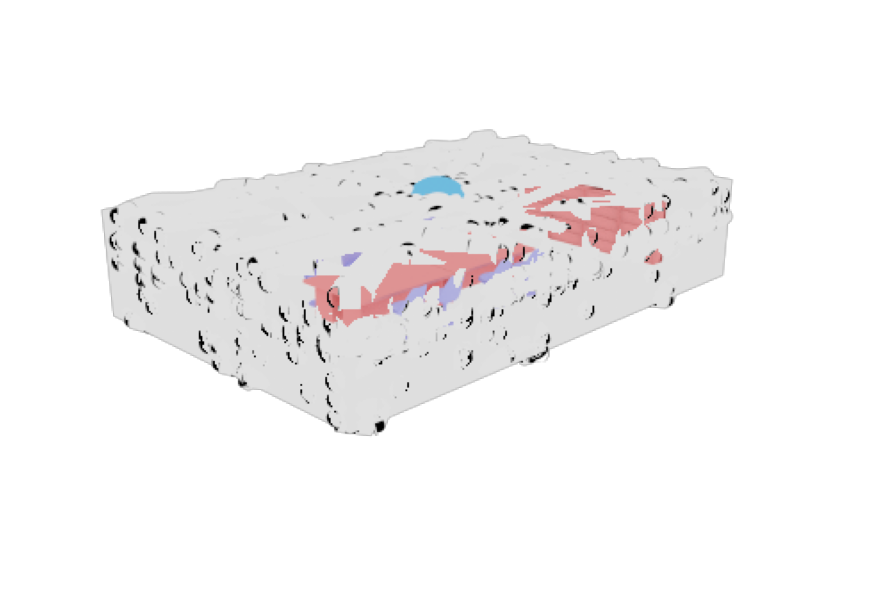

In [ ]:
# Compute propagation paths
paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6)  # Number of rays shot into directions defined
                                              # by a Fibonacci sphere , too few rays can
                                              # lead to missing paths

# Visualize paths in the 3D preview
camname = "test1"
my_cam = Camera(camname, position=[20, 20, 10], look_at=[0,0,0])
scene.render(my_cam, paths=paths, show_devices=True, show_paths=True, resolution=resolution);


In [ ]:
# Show the coordinates of the starting points of all rays.
# These coincide with the location of the transmitters.
print("Source coordinates: ", paths.sources.numpy())
print("Transmitter coordinates: ", list(scene.transmitters.values())[0].position.numpy())

# Show the coordinates of the endpoints of all rays.
# These coincide with the location of the receivers.
print("Target coordinates: ",paths.targets.numpy())
print("Receiver coordinates: ",list(scene.receivers.values())[0].position.numpy())

# Show the types of all paths:
# 0 - LoS, 1 - Reflected, 2 - Diffracted, 3 - Scattered
# Note that Diffraction and scattering are turned off by default.
print("Path types: ", paths.types.numpy())
print(f'number of paths: {len(np.squeeze(paths.types.numpy()))}')

Source coordinates:  [[0.  0.  2.5]]
Transmitter coordinates:  [0.  0.  2.5]
Target coordinates:  [[2.  2.  1.5]]
Receiver coordinates:  [2.  2.  1.5]
Path types:  [[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1]]
number of paths: 153


In [ ]:
# We can now access for every path the channel coefficient, the propagation delay,
# as well as the angles of departure and arrival, respectively (zenith and azimuth).

# Let us inspect a specific path in detail
path_idx = 0 # Try out other values in the range [0, 13]

# For a detailed overview of the dimensions of all properties, have a look at the API documentation
print(f"\n--- Detailed results for path {path_idx} ---")
print(f"Channel coefficient: {paths.a[0,0,0,0,0,path_idx, 0].numpy()}")
print(f"Propagation delay: {paths.tau[0,0,0,path_idx].numpy()*1e6:.5f} us")
print(f"Zenith angle of departure: {paths.theta_t[0,0,0,path_idx]:.4f} rad")
print(f"Azimuth angle of departure: {paths.phi_t[0,0,0,path_idx]:.4f} rad")
print(f"Zenith angle of arrival: {paths.theta_r[0,0,0,path_idx]:.4f} rad")
print(f"Azimuth angle of arrival: {paths.phi_r[0,0,0,path_idx]:.4f} rad")


--- Detailed results for path 0 ---
Channel coefficient: (4.677789183915593e-05+9.701277108031814e-12j)
Propagation delay: 0.00000 us
Zenith angle of departure: 1.9106 rad
Azimuth angle of departure: 0.7854 rad
Zenith angle of arrival: 1.2310 rad
Azimuth angle of arrival: -2.3562 rad


In [ ]:
# Default parameters in the PUSCHConfig
subcarrier_spacing = 15e3
fft_size = 48


In [ ]:
# Print shape of channel coefficients before the application of Doppler shifts
# The last dimension corresponds to the number of time steps which defaults to one
# as there is no mobility
print("Shape of `a` before applying Doppler shifts: ", paths.a.shape)

# Apply Doppler shifts => probably don't need this
paths.apply_doppler(sampling_frequency=subcarrier_spacing, # Set to 15e3 Hz
                    num_time_steps=1) # Or rx speeds

print("Shape of `a` after applying Doppler shifts: ", paths.a.shape)

a, tau = paths.cir()
print("Shape of tau: ", tau.shape)

Shape of `a` before applying Doppler shifts:  (1, 1, 2, 1, 4, 153, 1)
Shape of `a` after applying Doppler shifts:  (1, 1, 2, 1, 4, 153, 1)
Shape of tau:  (1, 1, 1, 153)


tf.Tensor(
[ 4.67778918e-05+9.7012771e-12j -4.48933179e-06+4.7211070e-06j
 -3.28740157e-06+1.7821706e-06j  6.41107772e-06+5.4879038e-06j
  4.60907086e-06-4.4312292e-06j  3.13775581e-06-2.2825286e-06j
  7.57085536e-06-3.9958436e-06j -2.88863907e-06+4.9039509e-06j
  3.22429719e-06+5.1790644e-06j  4.56120551e-06+4.2259749e-06j
 -1.14007150e-06-6.1388359e-06j  3.78068148e-06-6.7906768e-07j
  2.12010286e-06+5.0711660e-06j  1.81745543e-06+4.5153974e-06j
 -5.84253439e-06-2.7351720e-07j  2.69828843e-06+4.3418340e-06j
 -1.94660220e-06+3.4549339e-06j -2.80447966e-06-2.3187595e-06j
  1.74123784e-06+2.5032705e-06j  6.73674322e-07+2.2189454e-06j
  3.90691548e-06+2.2769461e-06j -4.89014337e-06-1.7572224e-06j
  4.73675664e-06+2.4100459e-06j  4.46152853e-06+4.5053304e-07j
 -3.04743412e-06+1.5282607e-06j -3.27966995e-06+2.5960310e-06j
  2.89584978e-06-2.5016020e-06j  1.28414354e-06+2.2868521e-06j
 -4.80598430e-07+3.6770182e-06j -1.89840978e-06-1.1457960e-06j
 -3.38786731e-06+2.7338212e-06j -1.73565297e

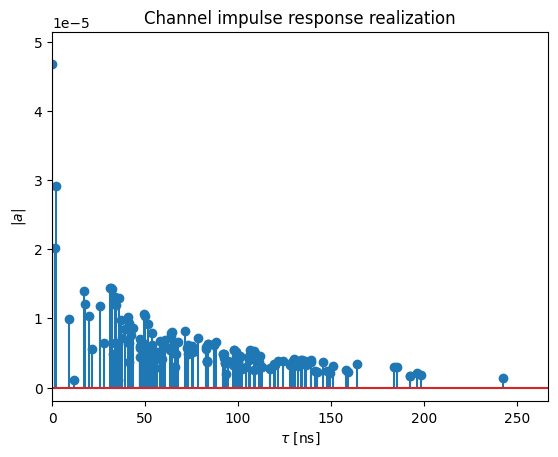

In [ ]:
t = tau[0,0,0,:]/1e-9 # Scale to ns
print(a[0,0,0,0,0,:,0])
a_abs = np.abs(a)[0,0,0,0,0,:,0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");


In [ ]:
#Note that the delay of the first arriving path is normalized to zero.
#This behavior can be changed using the Paths' call property normalize_delays.
# Disable normalization of delays
paths.normalize_delays = False

# Get only the LoS path
_, tau = paths.cir(los=True, reflection=False)
print("Delay of first path without normalization: ", np.squeeze(tau))

paths.normalize_delays = True
_, tau = paths.cir(los=True, reflection=False)
print("Delay of first path with normalization: ", np.squeeze(tau))

Delay of first path without normalization:  1.0006923e-08
Delay of first path with normalization:  0.0


In [ ]:
# Compute frequencies of subcarriers and center around carrier frequency
frequencies = subcarrier_frequencies(fft_size, subcarrier_spacing)

# Compute the frequency response of the channel at frequencies.
h_freq = cir_to_ofdm_channel(frequencies,
                             a,
                             tau,
                             normalize=True) # Non-normalized includes path-loss

'''h_freq is the one we need, shape is: [batch size, numrx, numrxant, numtx, numtxant, num_time_steps, fftsize]
=> we will only look at 1 subcarier and work with it as a freq flat channel, eg if fftsize is 48, we use subcarier 28
num_time_steps can be adjusted in the apply doppler function, will probably be set to 1? because we assume stationarity for the moment?,
could be adjusted based on the data of Alex


todo:
- maybe plot a few h_freqs to get a visual of the different subcariers

 '''

# Verify that the channel power is normalized
h_avg_power = tf.reduce_mean(tf.abs(h_freq)**2).numpy()

print("Shape of h_freq: ", h_freq.shape)
print("Average power h_freq: ", h_avg_power) # Channel is normalized


print(f'{h_freq[0, 0, 0, 0, 0, 0, 0]}')
print(f'{h_freq[0, 0, 1, 0, 0, 0, 0]}')

Shape of h_freq:  (1, 1, 2, 1, 4, 1, 48)
Average power h_freq:  1.0000001
(0.8822600841522217+1.2182048559188843j)
(1.0438860654830933+0.6368253827095032j)
